In [1]:
import pandas as pd # 基本ライブラリ
import numpy as np # 基本ライブラリ
import matplotlib.pyplot as plt # グラフ描画用
from matplotlib import pyplot as plt
# matplotlibに日本語を表示させる為に必要
plt.rcParams['font.family'] = 'IPAexGothic'
%matplotlib inline
import japanize_matplotlib
import seaborn as sns; sns.set() # グラフ描画用
import warnings # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error # モデル評価用(平均二乗誤差)
from sklearn.metrics import r2_score # モデル評価用(決定係数)
import lightgbm as lgb

In [2]:
dfbat = pd.read_pickle('dfbat.pickle')

In [6]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

### Light GBM（チーム含まず）

#### モデル作成

In [4]:
dfbat['japan'].replace(True,1,inplace = True)
dfbat['japan'].replace(False,0,inplace = True)

In [7]:
dfbat.head()

,player,team,salary,position,year,age,birthplace,AVG_-1y,AVG_-2y,AVG_-3y,game_-1y,game_-2y,game_-3y,PA_-1y,PA_-2y,PA_-3y,At_bat_-1y,At_bat_-2y,At_bat_-3y,hit_-1y,hit_-2y,hit_-3y,HR_-1y,HR_-2y,HR_-3y,RBI_-1y,RBI_-2y,RBI_-3y,steal_-1y,steal_-2y,steal_-3y,4ball_-1y,4ball_-2y,4ball_-3y,dead_ball_-1y,dead_ball_-2y,dead_ball_-3y,strikeout_-1y,strikeout_-2y,strikeout_-3y,bunt_-1y,bunt_-2y,bunt_-3y,GDP_-1y,GDP_-2y,GDP_-3y,OBP_-1y,OBP_-2y,OBP_-3y,SLG_-1y,SLG_-2y,SLG_-3y,OPS_-1y,OPS_-2y,OPS_-3y,RC27_-1y,RC27_-2y,RC27_-3y,japan
0,吉田 正尚,オリックス,28000.0,外野手,2021,28.0,福井,0.350,0.322,0.321,120.0,143.0,143.0,492.0,610.0,598.0,408.0,521.0,514.0,143.0,168.0,165.0,14.0,29.0,26.0,64.0,85.0,86.0,8.0,5.0,3.0,72.0,79.0,69.0,8.0,5.0,7.0,29.0,64.0,74.0,0.0,0.0,0.0,6.0,12.0,9.0,0.453,0.413,0.403,0.512,0.543,0.553,0.966,0.956,0.956,9.23,8.33,8.27,1
1,鈴木 誠也,広島,31000.0,外野手,2021,27.0,東京,0.300,0.335,0.320,118.0,140.0,124.0,514.0,612.0,520.0,430.0,499.0,422.0,129.0,167.0,135.0,25.0,28.0,30.0,75.0,87.0,94.0,6.0,25.0,4.0,72.0,103.0,88.0,9.0,7.0,5.0,73.0,81.0,116.0,0.0,0.0,0.0,15.0,3.0,4.0,0.409,0.453,0.438,0.544,0.565,0.618,0.953,1.018,1.057,7.67,9.68,10.02,1
2,坂倉 将吾,広島,1800.0,捕手,2021,23.0,千葉,0.287,NaN,NaN,81.0,NaN,NaN,228.0,NaN,NaN,209.0,NaN,NaN,60.0,NaN,NaN,3.0,NaN,NaN,26.0,NaN,NaN,1.0,NaN,NaN,17.0,NaN,NaN,2.0,NaN,NaN,36.0,NaN,NaN,0.0,NaN,NaN,6.0,NaN,NaN,0.346,NaN,NaN,0.411,NaN,NaN,0.758,NaN,NaN,4.93,NaN,NaN,1
3,近本 光司,阪神,7500.0,外野手,2021,27.0,兵庫,0.293,0.271,NaN,120.0,142.0,NaN,519.0,640.0,NaN,474.0,586.0,NaN,139.0,159.0,NaN,9.0,9.0,NaN,45.0,42.0,NaN,31.0,36.0,NaN,30.0,31.0,NaN,7.0,6.0,NaN,61.0,110.0,NaN,7.0,14.0,NaN,4.0,2.0,NaN,0.344,0.313,NaN,0.416,0.375,NaN,0.759,0.689,NaN,5.46,4.25,NaN,1
4,森 友哉,西武,16000.0,捕手,2021,26.0,大阪,0.251,0.329,0.275,104.0,135.0,136.0,405.0,573.0,552.0,358.0,492.0,473.0,90.0,162.0,130.0,9.0,23.0,16.0,38.0,105.0,80.0,4.0,3.0,7.0,38.0,72.0,70.0,3.0,2.0,2.0,67.0,89.0,105.0,2.0,1.0,0.0,7.0,9.0,3.0,0.325,0.413,0.366,0.380,0.547,0.457,0.705,0.959,0.823,4.32,8.38,6.38,1


In [10]:
test = dfbat[dfbat['year']==2021].drop(['player','team','birthplace'],axis = 1)
train = dfbat[dfbat['year']!=2021].drop(['player','team','birthplace'],axis = 1)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test['position_le'] = le.fit_transform(test['position'])
train['position_le'] = le.fit_transform(train['position'])

test = test.drop(['position'],axis = 1)
train = train.drop(['position'],axis = 1)

x_test = test.drop('salary',axis = 1)
y_test = test['salary']

x_train = train.drop('salary',axis = 1)
y_train = train['salary']

train_set = lgb.Dataset(x_train, y_train)
test_set = lgb.Dataset(x_test, y_test)

In [11]:
params = {
    "objective" : "regression",
    "metric" : "rmse"
}

model = lgb.train(
    params = params,
    train_set = train_set,
    valid_sets = [train_set, test_set],
    num_boost_round = 100
)

y_pred = model.predict(x_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6187
[LightGBM] [Info] Number of data points in the train set: 907, number of used features: 55
[LightGBM] [Info] Start training from score 10268.125689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 12925.4	valid_1's rmse: 13163.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 12068.2	valid_1's rmse: 12464.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 11269.2	valid_1's rmse: 11828.4
[4]	training's rmse: 10559.7	valid_1's rmse: 11490.9
[5]	training's rmse: 9893.99	valid_1's rmse: 11184.6
[6]	training's rmse: 9327.18	valid_1's rmse: 10857
[7]	training's rmse: 8843.88	valid_1's rmse: 10569.6
[8]	training's rmse: 8388.56	valid_1's rmse: 10411.6
[9]	tr

#### モデルの評価

In [14]:
# rmse : 平均二乗誤差の平方根
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) 
print('RMSE :',rmse)

# r2 : 決定係数
r2 = r2_score(y_test,y_pred)
print('R2 :',r2)

RMSE : 8511.501887651184
R2 : 0.6011061393367814


In [15]:
result_data = {}
model = lgb.train(
    params = params,
    train_set = train_set,
    valid_sets = [train_set, test_set],
    num_boost_round = 100,
    evals_result = result_data)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6187
[LightGBM] [Info] Number of data points in the train set: 907, number of used features: 55
[LightGBM] [Info] Start training from score 10268.125689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 12925.4	valid_1's rmse: 13163.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 12068.2	valid_1's rmse: 12464.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 11269.2	valid_1's rmse: 11828.4
[4]	training's rmse: 10559.7	valid_1's rmse: 11490.9
[5]	training's rmse: 9893.99	valid_1's rmse: 11184.6
[6]	training's rmse: 9327.18	valid_1's rmse: 10857
[7]	training's rmse: 8843.88	valid_1's rmse: 10569.6
[8]	training's rmse: 8388.56	valid_1's rmse: 10411.6
[9]	tr

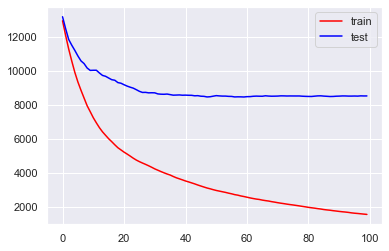

In [16]:
plt.plot(result_data["training"]["rmse"], color = "red", label = "train")
plt.plot(result_data["valid_1"]["rmse"], color = "blue", label = "test")
plt.legend()
plt.show()

In [17]:
feat_cols = x_train.columns.tolist()

##### 重要度の計算

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

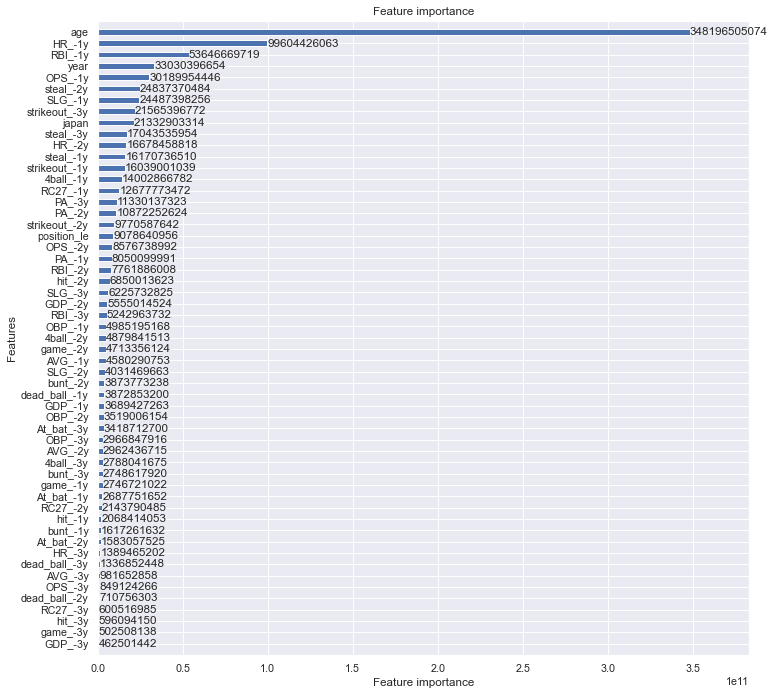

In [18]:
lgb.plot_importance(model, height = 0.5, figsize=(12,12),dpi = 70, importance_type='gain',precision = 0)

### プレイヤーの評価

In [19]:
df_pred = pd.DataFrame({'player':dfbat[dfbat['year']==2021]['player'],
                        'team':dfbat[dfbat['year']==2021]['team'],
                        'age': dfbat[dfbat['year']==2021]['age'],
                        'salary':y_test,'salary_pred':y_pred})
df_pred['diff'] = df_pred['salary'] - df_pred['salary_pred']
df_pred['diff_ratio'] = df_pred['salary'] / df_pred['salary_pred']
df_pred.sort_values('diff',ascending = False)

,player,team,age,salary,salary_pred,diff,diff_ratio
66,ジョーンズ,オリックス,36.0,44000.0,16687.923833,27312.076167,2.636637
64,松田 宣浩,ソフトバンク,38.0,45000.0,17798.355843,27201.644157,2.528323
10,柳田 悠岐,ソフトバンク,33.0,61000.0,38777.626080,22222.373920,1.573072
80,今宮 健太,ソフトバンク,30.0,29000.0,9251.914001,19748.085999,3.134487
5,グラシアル,ソフトバンク,36.0,35000.0,16031.736288,18968.263712,2.183170
33,坂本 勇人,巨人,33.0,50000.0,34332.459283,15667.540717,1.456348
45,青木 宣親,ヤクルト,39.0,33000.0,18650.082032,14349.917968,1.769429
55,中村 晃,ソフトバンク,32.0,24000.0,9955.292349,14044.707651,2.410778
36,浅村 栄斗,楽天,31.0,50000.0,37985.189753,12014.810247,1.316302
29,山田 哲人,ヤクルト,29.0,50000.0,40140.207401,9859.792599,1.245634


In [20]:
df_pred.groupby('team').mean()['diff'].sort_values(ascending = False)

team
ソフトバンク    10687.323978
広島          423.091785
オリックス       182.513169
西武         -421.313868
楽天         -676.582002
日本ハム       -828.071493
巨人        -1676.409602
中日        -1810.941884
ヤクルト      -2260.150706
ロッテ       -2492.165837
DeNA      -3882.361292
阪神        -4569.605098
Name: diff, dtype: float64

In [21]:
df_pred.sort_values('diff_ratio',ascending = False)

,player,team,age,salary,salary_pred,diff,diff_ratio
80,今宮 健太,ソフトバンク,30.0,29000.0,9251.914001,19748.085999,3.134487
66,ジョーンズ,オリックス,36.0,44000.0,16687.923833,27312.076167,2.636637
64,松田 宣浩,ソフトバンク,38.0,45000.0,17798.355843,27201.644157,2.528323
85,佐藤 都志也,ロッテ,23.0,1600.0,635.983337,964.016663,2.515789
55,中村 晃,ソフトバンク,32.0,24000.0,9955.292349,14044.707651,2.410778
5,グラシアル,ソフトバンク,36.0,35000.0,16031.736288,18968.263712,2.183170
51,栗山 巧,西武,38.0,17000.0,9473.533110,7526.466890,1.794473
50,大和,DeNA,34.0,10000.0,5624.603257,4375.396743,1.777903
45,青木 宣親,ヤクルト,39.0,33000.0,18650.082032,14349.917968,1.769429
59,渡邉 諒,日本ハム,26.0,5500.0,3271.926704,2228.073296,1.680967


### Light GBM（チーム含む）

#### モデル作成

In [213]:
dfbat['japan'].replace(True,1,inplace = True)
dfbat['japan'].replace(False,0,inplace = True)

In [22]:
test1 = dfbat[dfbat['year']==2021].drop(['player','birthplace'],axis = 1)
train1 = dfbat[dfbat['year']!=2021].drop(['player','birthplace'],axis = 1)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test1['team_le'] = le.fit_transform(test1['team'])
train1['team_le'] = le.fit_transform(train1['team'])

test1['position_le'] = le.fit_transform(test1['position'])
train1['position_le'] = le.fit_transform(train1['position'])

test1 = test1.drop(['position','team'],axis = 1)
train1 = train1.drop(['position','team'],axis = 1)

x_test1 = test1.drop('salary',axis = 1)
y_test1 = test1['salary']

x_train1 = train1.drop('salary',axis = 1)
y_train1 = train1['salary']

train_set1 = lgb.Dataset(x_train1, y_train1)
test_set1 = lgb.Dataset(x_test1, y_test1)

In [23]:
params1 = {
    "objective" : "regression",
    "metric" : "rmse"
}

model1 = lgb.train(
    params = params,
    train_set = train_set1,
    valid_sets = [train_set1, test_set1],
    num_boost_round = 100
)

y_pred1 = model1.predict(x_test1)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6199
[LightGBM] [Info] Number of data points in the train set: 907, number of used features: 56
[LightGBM] [Info] Start training from score 10268.125689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 12925.4	valid_1's rmse: 13163.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 12068.2	valid_1's rmse: 12464.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 11269.2	valid_1's rmse: 11828.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 10559.7	valid_1's rmse: 11490.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 9894	valid_1's rmse: 11184.6
[LightGBM] [Warn

#### モデルの評価

In [24]:
# rmse : 平均二乗誤差の平方根
mse1 = mean_squared_error(y_test1, y_pred1)
rmse1 = np.sqrt(mse1) 
print('RMSE :',rmse1)

# r2 : 決定係数
r21 = r2_score(y_test1,y_pred1)
print('R2 :',r21)

RMSE : 7896.986380381605
R2 : 0.6566257446674404


In [25]:
result_data1 = {}
model1 = lgb.train(
    params = params1,
    train_set = train_set1,
    valid_sets = [train_set1, test_set1],
    num_boost_round = 100,
    evals_result = result_data1)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6199
[LightGBM] [Info] Number of data points in the train set: 907, number of used features: 56
[LightGBM] [Info] Start training from score 10268.125689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 12925.4	valid_1's rmse: 13163.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 12068.2	valid_1's rmse: 12464.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 11269.2	valid_1's rmse: 11828.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 10559.7	valid_1's rmse: 11490.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 9894	valid_1's rmse: 11184.6
[LightGBM] [Warn

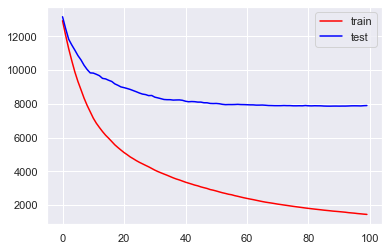

In [26]:
plt.plot(result_data1["training"]["rmse"], color = "red", label = "train")
plt.plot(result_data1["valid_1"]["rmse"], color = "blue", label = "test")
plt.legend()
plt.show()

In [27]:
feat_cols1 = x_train1.columns.tolist()

##### 重要度の計算

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

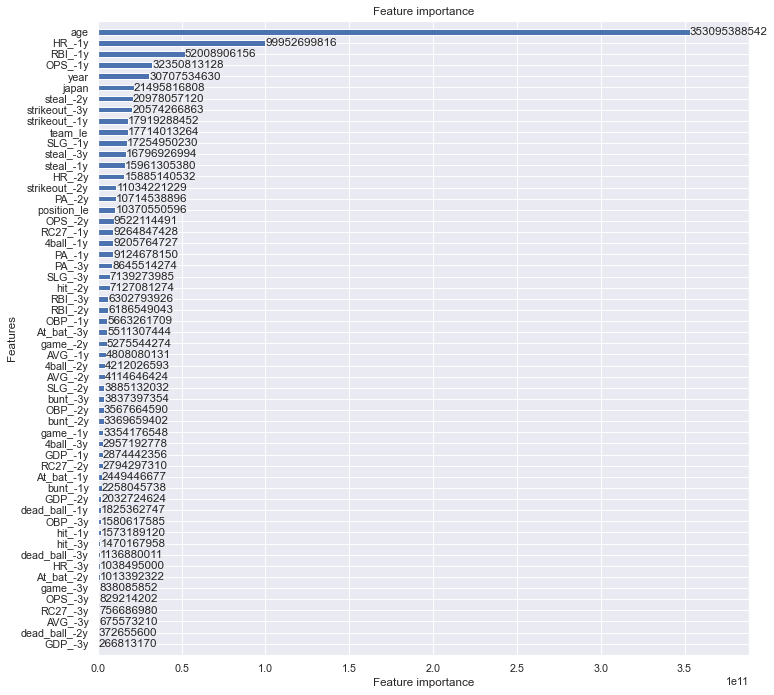

In [28]:
lgb.plot_importance(model1, height = 0.5, figsize=(12,12),dpi = 70, importance_type='gain',precision = 0)

### プレイヤーの評価

In [29]:
df_pred1 = pd.DataFrame({'player':dfbat[dfbat['year']==2021]['player'],
                        'team':dfbat[dfbat['year']==2021]['team'],
                        'salary':y_test1,'salary_pred':y_pred1})
df_pred1['diff'] = df_pred1['salary'] - df_pred1['salary_pred']
df_pred1['diff_ratio'] = df_pred1['salary'] / df_pred1['salary_pred']
df_pred1.sort_values('diff',ascending = False)

,player,team,salary,salary_pred,diff,diff_ratio
66,ジョーンズ,オリックス,44000.0,16845.164051,27154.835949,2.612026
64,松田 宣浩,ソフトバンク,45000.0,22873.091746,22126.908254,1.967377
80,今宮 健太,ソフトバンク,29000.0,10166.344065,18833.655935,2.852550
5,グラシアル,ソフトバンク,35000.0,19250.668768,15749.331232,1.818119
10,柳田 悠岐,ソフトバンク,61000.0,47086.070541,13913.929459,1.295500
36,浅村 栄斗,楽天,50000.0,36610.446112,13389.553888,1.365730
55,中村 晃,ソフトバンク,24000.0,10674.571939,13325.428061,2.248334
33,坂本 勇人,巨人,50000.0,36762.324297,13237.675703,1.360088
45,青木 宣親,ヤクルト,33000.0,21547.461385,11452.538615,1.531503
29,山田 哲人,ヤクルト,50000.0,38693.492441,11306.507559,1.292207


In [30]:
df_pred1.sort_values('diff_ratio',ascending = False)

,player,team,salary,salary_pred,diff,diff_ratio
34,中島 宏之,巨人,5000.0,1637.330977,3362.669023,3.053750
80,今宮 健太,ソフトバンク,29000.0,10166.344065,18833.655935,2.852550
66,ジョーンズ,オリックス,44000.0,16845.164051,27154.835949,2.612026
58,安田 尚憲,ロッテ,2200.0,975.946428,1224.053572,2.254222
55,中村 晃,ソフトバンク,24000.0,10674.571939,13325.428061,2.248334
64,松田 宣浩,ソフトバンク,45000.0,22873.091746,22126.908254,1.967377
44,安達 了一,オリックス,9000.0,4594.627971,4405.372029,1.958809
81,中川 圭太,オリックス,2200.0,1179.049803,1020.950197,1.865909
5,グラシアル,ソフトバンク,35000.0,19250.668768,15749.331232,1.818119
50,大和,DeNA,10000.0,5648.214578,4351.785422,1.770471
